place 사진 기반으로 이 곳이 garden인지, highway인지 등을 알아보는 model 만들기

우선 place 폴더에 들어가있는 garden, highway, nightview 가지고 개발 및 테스트를 해보자.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%matplotlib inline
import os
import time
import random

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

import torchvision
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm



In [3]:
# data 경로 설정 
root = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks")

In [4]:
# device 값 가져오기
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
#train_folder = os.listdir(os.path.join(root,"Place"))
train_folder = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks","Place")
print(len(train_folder))
train_folder # label list

44


'/content/drive/MyDrive/Colab Notebooks/Place'

In [6]:
# 데이터 전처리에 사용할 transform 
transform = transforms.Compose([
      transforms.Resize((256, 256)), 
      transforms.ToTensor()
])


# data load
# split train, test data
full_data = datasets.ImageFolder(os.path.join(root, "Place"), transform)
train_size = int(0.8*len(full_data))
test_size = len(full_data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_data, [train_size, test_size])

In [7]:
# get train, valid data loader 

def get_train_valid_loader(batch_size, valid_size=0.2):

  # validation 으로 사용할 indices 발라내자
  num_train = len(train_dataset)
  indices = list(range(num_train))
  np.random.shuffle(indices)
  split = int(np.floor(valid_size * num_train))
  train_idx, valid_idx = indices[split:], indices[:split]

  train_sampler = SubsetRandomSampler(train_idx)
  valid_sampler = SubsetRandomSampler(valid_idx)

  # load training data in batches
  train_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=batch_size,
                                             sampler=train_sampler,
                                             num_workers=4)

    # load validation data in batches
  valid_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=batch_size,
                                             sampler=valid_sampler,
                                             num_workers=4)


  return train_loader, valid_loader

  

In [8]:
# get test loader

def get_test_loader(batch_size):
  test_loader = torch.utils.data.DataLoader(test_dataset, 
                                            batch_size=batch_size, 
                                            num_workers=4)

  return test_loader


In [9]:
def check_image_data(data, class_names, figsize=(20, 10)):
  fig = plt.figure(figsize=figsize)
  for i in range(18):
    img = data[i][0]
    ax = fig.add_subplot(3, 6, i+1)
    ax.imshow(img.permute(1,2,0))
    ax.set_title(f"Label: {class_names[data[i][1]]}")
  fig.show()
  pass

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train 데이터 셋크기: 5364
클래스:  ['baseballpark', 'beach', 'campsite', 'campus', 'city', 'coffee_shop_food', 'fairway', 'festival', 'field', 'garden_forest', 'mountain', 'parkinglot', 'river', 'ski_slope', 'supermarket', 'themepark', 'waterpark', 'zoo']


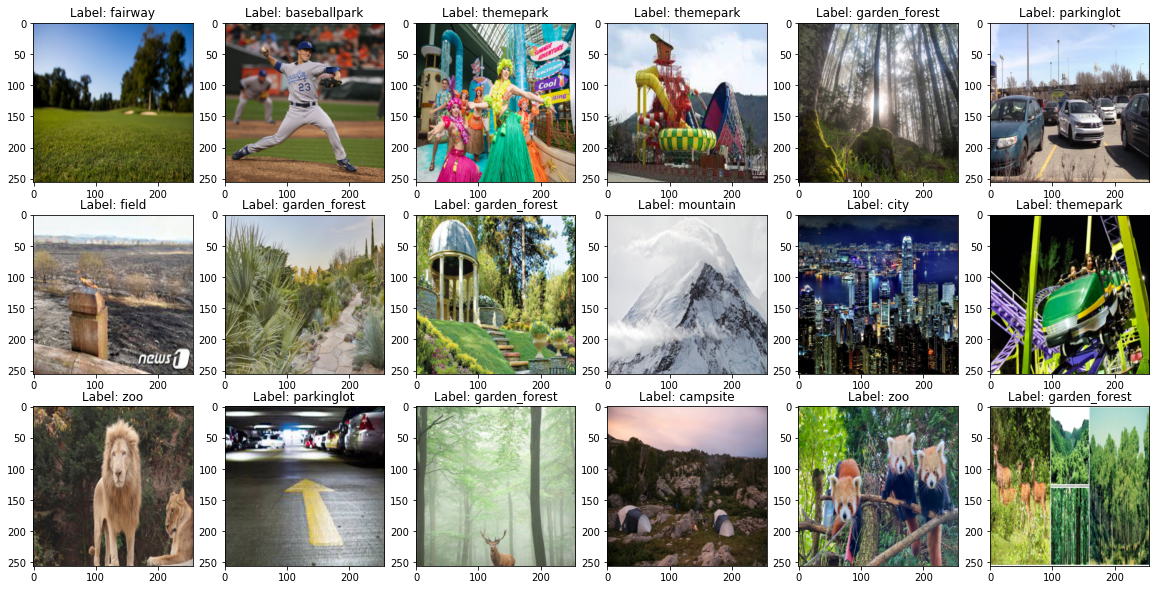

In [10]:
train_loader, valid_loader = get_train_valid_loader(batch_size=4, valid_size=0.2)
print('train 데이터 셋크기:', len(train_dataset))

class_names = train_dataset.dataset.classes
print('클래스: ', class_names)

check_image_data(train_dataset, class_names)

In [11]:
# test loader

test_loader = get_test_loader(batch_size = 4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [12]:
# 위에서 정리한 데이터 로더들 dataset으로 묶어주기 
dataset = [train_loader, valid_loader, test_loader]

In [13]:
# GPU 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


https://pytorch.org/hub/pytorch_vision_mobilenet_v2/

In [14]:
class PlaceTrainer(nn.Module):
  def __init__(self, model, dataset, opt = "adam", lr= 0.001, n_epochs=10, has_scheduler=False, device="cuda"):
    super().__init__()

    self.model = model
    self.n_epochs = n_epochs
    self.criterion = nn.CrossEntropyLoss()
    self._get_optimizer(opt = opt.lower(), lr = lr)
    self.has_scheduler = has_scheduler
    if self.has_scheduler : 
      self._get_scheduler()
    
    self.device = device
    self.train_data = dataset[0]
    self.valid_data = dataset[1]
    self.test_data = dataset[2]

  def _get_optimizer(self, opt, lr = 0.001):
    if opt == 'sgd':
      self.optimizer = torch.optim.SGD(params = self.model.parameters(), lr = lr)
    elif opt == 'adam':
      self.optimizer = torch.optim.Adam(params = self.model.parameters(), lr = lr)
    else :
      raise ValueError(f"optimizer {opt} is not supported")
  
  def _get_scheduler(self):
    self.scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer = self.optimizer, max_lr = 0.001,
                                                            steps_per_epoch = int(len(dataset[0])) * self.n_epochs,
                                                            epochs = self.n_epochs, anneal_strategy = 'linear')
  
  def train(self, train_loader, valid_loader, n_epochs, disp_epoch = 5):
    print("==============<< Train Start >>==============")
    history = {"train_loss" : [], "train_accuracy" : [], "valid_loss" : [], "valid_accuracy" : []}   
        
    for epoch in range(n_epochs) :
      correct_tr = 0
      total_tr = 0
      loss_tr = 0.0
      start_time = time.time()
            
      # Training
      for i, data in enumerate(train_loader) :
        inputs, labels = data[0].to(device), data[1].to(device)
    
        # Normalize
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        # Initiate the parameter gradients
        self.optimizer.zero_grad()

        # forward + backward + optimize
        outputs = self.model(inputs)
        loss = self.criterion(outputs, labels)
        loss.backward()
        self.optimizer.step()
        if self.has_scheduler :
          self.scheduler.step()

        # Stats the loss & accuracy
        loss_tr += loss.item()

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs, 1)
        correct_tr += (prediction == labels).sum().item()
        total_tr += prediction.shape[0]
                
      # Validation
      correct_val = 0
      total_val = 0
      loss_val = 0.0        
      predictions = []
            
      with torch.no_grad() :
        for data in valid_loader :
           inputs = data[0].to(self.device)
           val_labels = data[1].to(self.device)
                
           inputs_m, inputs_s = inputs.mean(), inputs.std()
           inputs = (inputs - inputs_m) / inputs_s                    
                   
           outputs = self.model(inputs)
           loss = self.criterion(outputs, val_labels)
           loss_val += loss.item()
                    
           _, prediction = torch.max(outputs, 1)
           predictions.append(prediction)
                    
           correct_val += (prediction == val_labels).sum().item()
           total_val += prediction.shape[0]
            
      accuracy_tr = correct_tr / total_tr
      accuracy_val = correct_val / total_val
      loss_tr = loss_tr / len(train_loader)
      loss_val = loss_val / len(valid_loader)
            
      history['train_loss'].append(loss_tr)
      history['train_accuracy'].append(accuracy_tr)
      history['valid_loss'].append(loss_val)
      history['valid_accuracy'].append(accuracy_val)                 
            
      if epoch % disp_epoch == 0 :
          print(f"Epoch : {epoch} / Tr_loss : {loss_tr:>6f}, Tr_accuracy : {accuracy_tr:>4f}, Val_loss : {loss_val:>6f}, Val_accuracy : {accuracy_val:>4f} / Time : {(time.time() - start_time):>6f}") 

    # Plot the graph of total training
    self.plot_history(history)

  def plot_history(self, history) :
    f, ax = plt.subplots(1,2, figsize = (10, 5))
      
    ax[0].plot(history["train_loss"], color='red', label='Train Loss')
    ax[0].plot(history['valid_loss'], color='blue', label='Valid Loss')
    ax[0].legend(loc='upper right')
    ax[0].set_title("LOSS")
    
    ax[1].plot(history['train_accuracy'], color='red', label='Train Accuracy')
    ax[1].plot(history['valid_accuracy'], color='blue', label='Valid Accuracy')
    ax[1].legend(loc='upper right')
    ax[1].set_title("ACCURACY")
        
    plt.tight_layout()
    plt.show()

  def test(self, test_loader) :
    print("==============<< Test Start >>==============")
    test_predictions = []
    results = []
    s_time = time.time()
    with torch.no_grad() :
      for data in tqdm(test_loader) :
        inputs = data[0].to(self.device)
        
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s
                
        outputs = self.model(inputs)
                
        _, prediction = torch.max(outputs, 1)
        test_predictions.append(prediction)
        
      for batch in test_predictions :
        for i in batch :
          results.append(i.item())
      print(f"===<< Test Completed / Time : {(time.time() - s_time):>6f} >>===")
      return results


In [15]:
inception_v3 = models.inception_v3(pretrained=True)
inception_v3.eval()
inception_v3

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [16]:
inception_v3 = models.inception_v3(pretrained=True)
inception_v3.eval()
inception_v3

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [17]:
trainer = PlaceTrainer(model=inception_v3, dataset=dataset, opt='adam', lr = 0.005, has_scheduler=True, device=device).to(device)

==============<< Train Start >>==============


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch : 0 / Tr_loss : 1.699198, Tr_accuracy : 0.500932, Val_loss : 1.350722, Val_accuracy : 0.597015 / Time : 320.929963


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency e

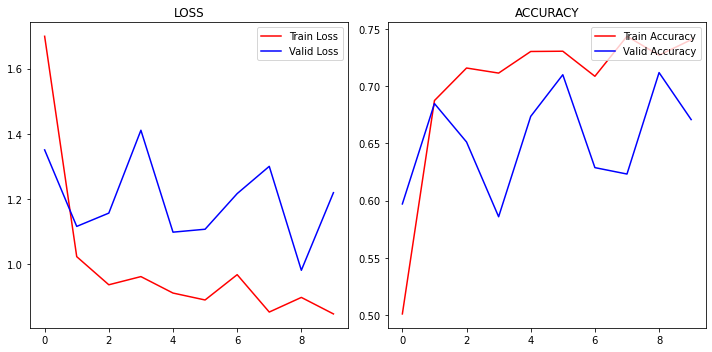

In [19]:
trainer.train(train_loader, valid_loader, n_epochs=10, disp_epoch=10)

In [20]:
results = trainer.test(test_loader)

==============<< Test Start >>==============


  0%|          | 0/336 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
 48%|████▊     | 160/336 [00:39<00:40,  4.40it/s]/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 79%|███████▉  | 267/336 [01:05<00:17,  3.94it/s]/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Tra

===<< Test Completed / Time : 83.620205 >>===


In [21]:
def check_result_image_data(data, class_names, result, figsize=(20, 10)):
  fig = plt.figure(figsize=figsize)
  for i in range(18):
    img = data[i][0]
    ax = fig.add_subplot(3, 6, i+1)
    ax.imshow(img.permute(1,2,0))
    ax.set_title((f"Original Label: {class_names[data[i][1]]} \n Predict Result: {class_names[result[i]]}"))
  fig.show()
  pass

test 데이터 셋크기: 1341
클래스:  ['baseballpark', 'beach', 'campsite', 'campus', 'city', 'coffee_shop_food', 'fairway', 'festival', 'field', 'garden_forest', 'mountain', 'parkinglot', 'river', 'ski_slope', 'supermarket', 'themepark', 'waterpark', 'zoo']


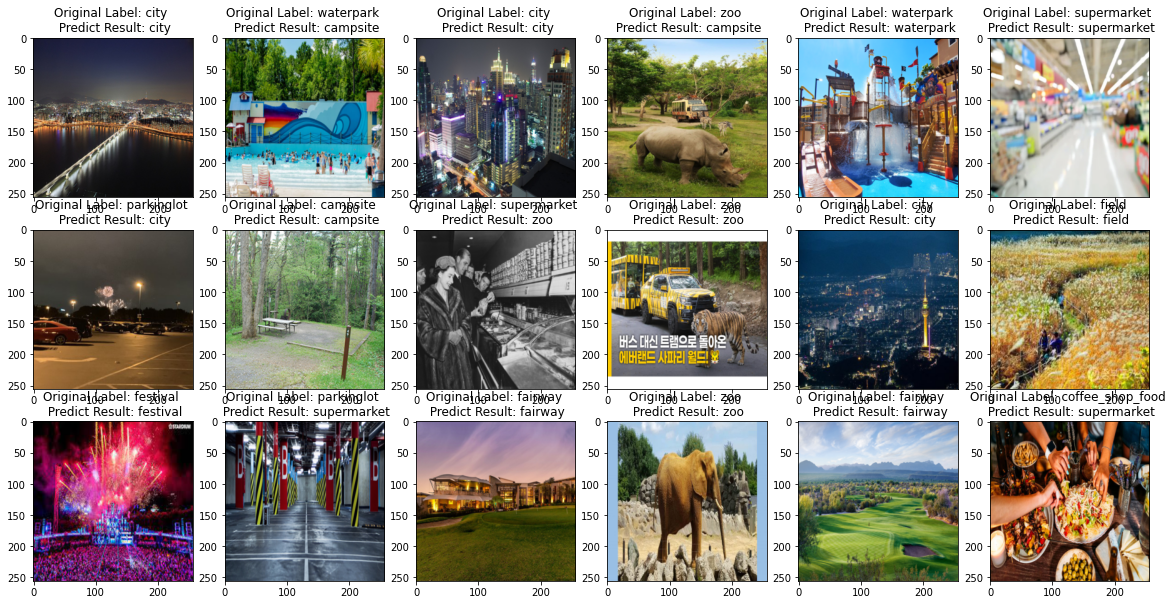

In [22]:
# check result data

print('test 데이터 셋크기:', len(test_dataset))

class_names = test_dataset.dataset.classes
print('클래스: ', class_names)

check_result_image_data(test_dataset, class_names, results)
